In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import joblib
import math
import numpy as np
import itertools 
from itertools import product
from collections import Counter
import garpar as gp
import re
import skcriteria as skc
from skcriteria import pipeline
from skcriteria.preprocessing import invert_objectives, weighters, scalers
from skcriteria.madm import similarity, moora, electre
from skcriteria.ranksrev import RankInvariantChecker
from garpar.datasets import make_multisector, RissoLevyStable, RissoNormal, RissoUniform
import warnings

/home/nadia/indicador/lib/python3.10/site-packages/skcriteria/pipeline.py:27: SKCriteriaDeprecationWarning: The 'skcriteria.pipeline' module is deprecated since 0.9 and will be removed in 1.0 Use 'skcriteria.pipelines' instead.
  deprecate.warn(
/home/nadia/indicador/lib/python3.10/site-packages/skcriteria/madm.py:30: SKCriteriaDeprecationWarning: 'skcriteria.madm' module is deprecated, use 'skcriteria.agg' instead
  utils.deprecate.warn(deprecation_reason)
/home/nadia/indicador/lib/python3.10/site-packages/skcriteria/agg/similarity.py:27: SKCriteriaDeprecationWarning: The module 'skcriteria.agg.similarity' is deprecated since v0.9 and will be removed in v1.0. Please use 'skcriteria.agg.topsis' instead.
  deprecate.warn(


In [2]:
#--- 1. Configuración de Parámetros Fijos (CORREGIDO) ---
NUM_ITERACIONES = 100
STOCKS_TOTALES = 6  # 💡 CAMBIO CLAVE: Un solo stock por sector
DIAS_SIMULACION = 7
VENTANAS_A_PROBAR = [3, 5, 7] 

# --- 2. Definición de Parámetros y PRECIOS PERSONALIZADOS (CORREGIDO) ---
PRECIOS_INICIALES_TOTAL = [
    200.0,  # alua
    300.0,  # Precio para el Stock 2 (Sector 2)
    150.0,
    100,
    100,
    800# Precio para el Stock 3 (Sector 3)
] 

# --- 3. Definición de Parámetros de Sectores (Sin Cambios) ---
params_A = {"alpha": 1.6411, "beta": -0.0126, "mu": 0.0005, "sigma": 0.005, "entropy": 0.5}
params_B = {"alpha": 2, "beta": -0.5, "mu": 0.0005, "sigma": 0.005, "entropy": 0.5}
params_C = {"alpha": 1.9, "beta": 0.1, "mu": 0.001, "sigma": 0.004, "entropy": 0.6}
params_D = {"alpha": 1.6411, "beta": -0.0126, "mu": 0.0005, "sigma": 0.005, "entropy": 0.5}
params_E = {"alpha": 1.6411, "beta": -0.0126, "mu": 0.0005, "sigma": 0.005, "entropy": 0.5}
params_F = {"alpha": 1.9, "beta": 0.1, "mu": 0.001, "sigma": 0.004, "entropy": 0.6}

parametros_sectores_base = [params_A, params_B, params_C, params_D, params_E]

# Diccionario para guardar todos los DataFrames: {Ventana: [df_corrida_1, df_corrida_2, ...]}
resultados_por_ventana = {ventana: [] for ventana in VENTANAS_A_PROBAR}

# --- 4. BUCLE DE SIMULACIÓN Y ALMACENAMIENTO ---

for VENTANA in VENTANAS_A_PROBAR:
    print(f"Iniciando {NUM_ITERACIONES} simulaciones para Ventana: {VENTANA} días...")
    
    for i in range(NUM_ITERACIONES):
        
        # Cálculo del random_state secuencial por bloque (i * 10000 + j * 100)
        random_seed_base = i * 10000 
        distribuciones_para_corrida = []
        
        for j, params in enumerate(parametros_sectores_base):
            semilla_sector = random_seed_base + (j * 100)
            params_corrida = params.copy() 
            params_corrida['random_state'] = semilla_sector
            distribuciones_para_corrida.append(RissoLevyStable(**params_corrida))

        # SIMULACIÓN DEL MERCADO
        stocksset = make_multisector(
            *distribuciones_para_corrida,
            stocks=STOCKS_TOTALES,
            days=DIAS_SIMULACION,
            window_size=VENTANA,
            price=PRECIOS_INICIALES_TOTAL 
        )
        
        # ALMACENAMIENTO DEL DATAFRAME DE PRECIOS
        df_simulacion = stocksset._prices_df 
        resultados_por_ventana[VENTANA].append(df_simulacion)
    
print("\n--- ¡Generación de Simulaciones Finalizada! ---")

Iniciando 100 simulaciones para Ventana: 3 días...
Iniciando 100 simulaciones para Ventana: 5 días...
Iniciando 100 simulaciones para Ventana: 7 días...

--- ¡Generación de Simulaciones Finalizada! ---


In [3]:
resultados_por_ventana

{3: [Stocks  rissolevystable_1_S0  rissolevystable_1_S1  rissolevystable_2_S0  \
  Days                                                                       
  0                 200.000000            300.000000            150.000000   
  1                 200.013163            300.009547            150.004554   
  2                 200.017952            300.017101            150.009037   
  3                 200.021572            300.015353            150.012329   
  4                 200.024124            300.025281            150.021387   
  5                 200.024549            300.039775            150.014714   
  6                 200.024915            300.039403            150.005393   
  7                 200.022983            300.029377            150.000311   
  
  Stocks  rissolevystable_3_S0  rissolevystable_4_S0  rissolevystable_5_S0  
  Days                                                                      
  0                 100.000000            100.000000        

In [4]:
# --- 0. CONFIGURACIÓN INICIAL ---
# Suprimir el warning común de garpar/pypfopt sobre matrices no positivas
warnings.filterwarnings('ignore', category=UserWarning, message='The covariance matrix is non positive semidefinite. Amending eigenvalues.')
warnings.filterwarnings('ignore', category=UserWarning, message="No risk_free_rate specified, coercing it")
# ⚠️ DEFINICIÓN DE LOS OPTIMIZADORES A PROBAR (Asumida)
optimizadores_a_probar = {
    "max_sharpe": gp.optimize.mean_variance.MVOptimizer(model='max_sharpe'),
    "markowitz_target_return": gp.optimize.mean_variance.Markowitz(target_return=0.001),
    "markowitz_target_risk1": gp.optimize.mean_variance.Markowitz(target_risk=0.325),
    "markowitz_target_risk2": gp.optimize.mean_variance.Markowitz(target_risk=0.30),
    "markowitz_target_risk3": gp.optimize.mean_variance.Markowitz(target_risk=0.275),
    "markowitz_target_risk4": gp.optimize.mean_variance.Markowitz(target_risk=0.225),
    "markowitz_target_risk5": gp.optimize.mean_variance.Markowitz(target_risk=0.20),
    "markowitz_target_risk6": gp.optimize.mean_variance.Markowitz(target_risk=0.175),


}

rows = []

print("--- INICIO DEL PROCESAMIENTO DE MÉTRICAS (Usando StocksSet) ---")

# --- 1. BUCLE DE PROCESAMIENTO SOBRE LOS RESULTADOS GUARDADOS ---

for VENTANA, lista_simulaciones in resultados_por_ventana.items():
    
    for i, df_corrida in enumerate(lista_simulaciones):
        
        corrida_id = i + 1
        stocks_number_base = len(df_corrida.columns)

        # 💡 MEJORA DE ROBUSTEZ: Intentar crear el StocksSet primero
        stocksset_corrida = None
        try:
            stocksset_corrida = gp.StocksSet.from_prices(df_corrida, window_size=VENTANA)
        except Exception as e:
            # Si el StocksSet falla (ej: datos malformados), registra el fallo para TODOS los modelos
            print(f"⚠️ Error al crear StocksSet (Corrida {corrida_id}, Ventana {VENTANA}): {e}. Saltando modelos.")
            
            for opt_name in optimizadores_a_probar.keys():
                rows.append({
                    "Ventana": VENTANA,
                    "Corrida": corrida_id,
                    "Modelo_Opt": opt_name,
                    "stocks_number": stocks_number_base, 
                    "Cross_Entropy": np.nan,
                    "Zheng_Entropy": np.nan,
                    "Div_Ratio": np.nan,
                    "CV_MC": np.nan,
                    "PDI": np.nan
                })
            continue # Pasa a la siguiente corrida
        
        # 2. ITERACIÓN SOBRE LOS MODELOS DE OPTIMIZACIÓN
        for opt_name, optimizador in optimizadores_a_probar.items():
            
            try:
                # 3. OPTIMIZACIÓN + PRUNING
                mopt = optimizador.optimize(stocksset_corrida).weights_prune()
                
                # 4. CÁLCULO DE MÉTRICAS (EXITOSO)
                metricas = {
                    "stocks_number": len(mopt.stocks),
                    "Cross_Entropy": mopt.div.cross_entropy(),
                    "Zheng_Entropy": mopt.div.zheng_entropy(),
                    "Div_Ratio": mopt.div.ratio(),
                    "CV_MC": (mopt.div.mrc() * mopt.weights).std() / (mopt.div.mrc() * mopt.weights).mean(),
                    "PDI": mopt.div.pdi(n_components=3, random_state=100)
                }

                # 5. GUARDAR RESULTADO EXITOSO
                rows.append({
                    "Ventana": VENTANA,
                    "Corrida": corrida_id,
                    "Modelo_Opt": opt_name, 
                    **metricas
                })

            except Exception as e:
                #  Garantizar que la fila de identificadores se guarde
                rows.append({
                    "Ventana": VENTANA,
                    "Corrida": corrida_id,
                    "Modelo_Opt": opt_name,
                    "stocks_number": stocks_number_base, 
                    "Cross_Entropy": np.nan,
                    "Zheng_Entropy": np.nan,
                    "Div_Ratio": np.nan,
                    "CV_MC": np.nan,
                    "PDI": np.nan
                })
            
# --- 2. CREACIÓN DEL DATAFRAME FINAL ---

df_metricas_simulacion = pd.DataFrame(rows)

# Esta línea ahora es segura, ya que 'rows' garantiza las claves de índice
df_metricas_simulacion = df_metricas_simulacion.set_index(["Ventana", "Corrida", "Modelo_Opt"])

print("\n--- ANÁLISIS COMPLETADO ---")
print(f"Total de resultados guardados: {len(df_metricas_simulacion)} filas.")
print(df_metricas_simulacion.head(9))


--- INICIO DEL PROCESAMIENTO DE MÉTRICAS (Usando StocksSet) ---


/home/nadia/indicador/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/nadia/indicador/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/nadia/indicador/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/nadia/indicador/lib/python3.10/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/nadia/indicador/lib/python3.10


--- ANÁLISIS COMPLETADO ---
Total de resultados guardados: 2400 filas.
                                         stocks_number  Cross_Entropy  \
Ventana Corrida Modelo_Opt                                              
3       1       max_sharpe                           5       4.913730   
                markowitz_target_return              6       0.119852   
                markowitz_target_risk1               5      14.027175   
                markowitz_target_risk2               5      13.992721   
                markowitz_target_risk3               5      13.993341   
                markowitz_target_risk4               5      14.023324   
                markowitz_target_risk5               5      14.042966   
                markowitz_target_risk6               5      14.066878   
        2       max_sharpe                           6       3.003324   

                                         Zheng_Entropy  Div_Ratio     CV_MC  \
Ventana Corrida Modelo_Opt                   

In [5]:
df_metricas_simulacion[(df_metricas_simulacion.index.get_level_values('Ventana') == 3) &
    (df_metricas_simulacion.index.get_level_values('Corrida') ==10)]

stocks_number  Cross_Entropy  \
Ventana Corrida Modelo_Opt                                              
3       10      max_sharpe                           6            NaN   
                markowitz_target_return              6       0.000299   
                markowitz_target_risk1               5      13.664552   
                markowitz_target_risk2               5      13.736235   
                markowitz_target_risk3               5      13.749644   
                markowitz_target_risk4               5      13.721067   
                markowitz_target_risk5               5      13.633631   
                markowitz_target_risk6               6      14.271705   

                                         Zheng_Entropy  Div_Ratio     CV_MC  \
Ventana Corrida Modelo_Opt                                                    
3       10      max_sharpe                         NaN        NaN       NaN   
                markowitz_target_return   1.791465e+00   0.104872  1.394632   
                markowitz_target_risk1    4.659959e-07   0.062994  2.236068   
                markowitz_target_risk2    4.274902e-07   0.062994  2.236068   
                markowitz_target_risk3    4.212575e-07   0.062994  2.236068   
                markowitz_target_risk4    4.344246e-07   0.062994  2.236068   
                markowitz_target_risk5    4.774084e-07   0.062994  2.236068   
                markowitz_target_risk6    5.265515e-07   0.062994  2.449490   

                                              PDI  
Ventana Corrida Modelo_Opt                         
3       10      max_sharpe                    NaN  
                markowitz_target_return  1.301219  
                markowitz_target_risk1   1.304506  
                markowitz_target_risk2   1.304506  
                markowitz_target_risk3   1.304506  
                markowitz_target_risk4   1.304506  
                markowitz_target_risk5   1.304506  
                markowitz_target_risk6   1.301219

In [18]:
df_metricas_simulacion[(df_metricas_simulacion.index.get_level_values('Ventana') == 3) &
    (df_metricas_simulacion.index.get_level_values('Corrida') ==10)].droplevel('Ventana').droplevel('Corrida')

,stocks_number,Cross_Entropy,Zheng_Entropy,Div_Ratio,CV_MC,PDI
Modelo_Opt,,,,,,
max_sharpe,6,NaN,NaN,NaN,NaN,NaN
markowitz_target_return,6,0.000299,1.791465e+00,0.104872,1.394632,1.301219
markowitz_target_risk1,5,13.664552,4.659959e-07,0.062994,2.236068,1.304506
markowitz_target_risk2,5,13.736235,4.274902e-07,0.062994,2.236068,1.304506
markowitz_target_risk3,5,13.749644,4.212575e-07,0.062994,2.236068,1.304506
markowitz_target_risk4,5,13.721067,4.344246e-07,0.062994,2.236068,1.304506
markowitz_target_risk5,5,13.633631,4.774084e-07,0.062994,2.236068,1.304506
markowitz_target_risk6,6,14.271705,5.265515e-07,0.062994,2.449490,1.301219


In [7]:
#Eliminar corridas con NaN ===
# =========================================================================

# 1. Identificar el nivel del índice que representa la "corrida"
LEVEL_CORRIDA = 'Corrida' 

# 2. Inicializar una lista para guardar las corridas (índices) que deben eliminarse
corridas_a_eliminar = set()

# 3. Iterar sobre las corridas (grupos) para verificar NaNs
for corrida_id, group_df in df_metricas_simulacion.groupby(level=LEVEL_CORRIDA):
    
    # 4. Verificar si existe AL MENOS UN NaN en CUALQUIERA de las filas
    # .isnull() crea un DF booleano, .any(axis=None) verifica si hay True en todo el grupo.
    if group_df.isnull().any().any(): 
        # Si se encuentra un NaN, se añade el ID de la corrida a la lista de eliminación
        corridas_a_eliminar.add(corrida_id)

# 5. Filtrar el DataFrame original, excluyendo las corridas identificadas
# Creamos una máscara booleana: True para las corridas que NO están en la lista
mascara_mantener = ~df_metricas_simulacion.index.get_level_values(LEVEL_CORRIDA).isin(corridas_a_eliminar)

# Aplicar la máscara al DataFrame
df_metricas_limpio = df_metricas_simulacion[mascara_mantener]


In [8]:
df_metricas_limpio[df_metricas_limpio.index.get_level_values('Ventana') == 3].describe()

,stocks_number,Cross_Entropy,Zheng_Entropy,Div_Ratio,CV_MC,PDI
count,384.000000,384.000000,3.840000e+02,384.000000,384.000000,384.000000
mean,5.268229,10.342286,2.918436e-01,0.090668,2.125153,1.743796
std,0.927351,4.897050,5.636247e-01,0.079146,0.456403,0.290857
min,3.000000,0.000016,1.013680e-07,0.062994,0.208312,1.168720
25%,5.000000,10.145285,5.201931e-07,0.062994,2.000000,1.514529
50%,6.000000,12.795801,2.396267e-06,0.062994,2.236068,1.755222
75%,6.000000,13.616115,8.808643e-03,0.063182,2.449490,1.995468
max,6.000000,14.722921,1.791743e+00,0.835874,4.760203,2.595579


In [9]:
# =========================================================================
# === Definiciones 
# =========================================================================

# 1. Definición de Objetivos (idéntica a tu código)
objectives = [
    max, # 'stocks_number'
    min, # 'Cross_Entropy'
    max, # 'Zheng_Entropy'
    max, # 'Div_Ratio'
    min, # 'CV_MC'
    max, # 'PDI'
]

# 2. Identificar el nivel 'Ventana' que quieres filtrar (parece ser '3')
VENTANA_FILTRO = 3
LEVEL_VENTANA = 'Ventana'
LEVEL_CORRIDA = 'Corrida'

# 3. Filtrar por Ventana = 3 (esto simplifica la iteración)
df_ventana_3 = df_metricas_limpio[
    df_metricas_limpio.index.get_level_values(LEVEL_VENTANA) == VENTANA_FILTRO].copy()

# === PASO CRÍTICO: OBTENER LOS IDs DE CORRIDA REALES ===
# =========================================================================
# Obtenemos la lista ÚNICA de los identificadores de corrida que existen 
corridas_existentes = df_ventana_3.index.get_level_values('Corrida').unique().tolist()
corridas_existentes


[1,
 2,
 3,
 4,
 5,
 7,
 9,
 11,
 13,
 14,
 17,
 21,
 25,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 35,
 38,
 42,
 44,
 45,
 46,
 48,
 50,
 53,
 59,
 60,
 62,
 66,
 68,
 69,
 73,
 75,
 80,
 83,
 84,
 86,
 87,
 88,
 89,
 93,
 96,
 97,
 99]

In [26]:
# Diccionario para almacenar las Matrices de Decisión generadas
matrices_decision = {}

# Iteramos sobre los IDs de corrida REALES (ej: '10', '11'...)
for el_corrida_id in corridas_existentes:

    # 1. Filtramos el DataFrame de MÉTRICAS para la corrida actual
    df_filtrado = df_ventana_3[df_ventana_3.index.get_level_values('Corrida') == el_corrida_id].droplevel(['Ventana', 'Corrida'])
    
    # 2. ACCESO AL DATAFRAME ORIGINAL DE PESOS (Variable nueva solicitada)

    # === Extracción de elementos para skcriteria ===
    data = df_filtrado.to_numpy() 
    alternatives = df_filtrado.index 
    criteria = df_filtrado.columns 
    
    # === Generar la Matriz de Decisión ===
    dm = skc.mkdm(
        data, 
        objectives=objectives,
        alternatives=alternatives, 
        criteria=criteria
    )
    
    # Guardar la DM
    matrices_decision[el_corrida_id] = dm
matrices_decision[1]


/home/nadia/indicador/lib/python3.10/site-packages/pandas/io/formats/format.py:1354: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for val, m in zip(values.ravel(), mask.ravel())
/home/nadia/indicador/lib/python3.10/site-packages/pandas/io/formats/format.py:1354: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for val, m in zip(values.ravel(), mask.ravel())


,stocks_number[▲ 1.0],Cross_Entropy[▼ 1.0],Zheng_Entropy[▲ 1.0],Div_Ratio[▲ 1.0],CV_MC[▼ 1.0],PDI[▲ 1.0]
max_sharpe,5.0,4.913730,9.352603e-01,0.193362,2.433017,1.789501
markowitz_target_return,6.0,0.119852,1.673168e+00,0.293970,0.208312,1.748395
markowitz_target_risk1,5.0,14.027175,2.779528e-07,0.062994,2.236068,1.755222
markowitz_target_risk2,5.0,13.992721,2.885831e-07,0.062994,2.236068,1.755222
markowitz_target_risk3,5.0,13.993341,2.883620e-07,0.062994,2.236068,1.755222
markowitz_target_risk4,5.0,14.023324,2.792089e-07,0.062994,2.236068,1.755222
markowitz_target_risk5,5.0,14.042966,2.742439e-07,0.062994,2.236068,1.755222
markowitz_target_risk6,5.0,14.066878,2.695716e-07,0.062994,2.236068,1.755222


In [28]:
# 1. Definición del Pipeline
pipe_igual_vector = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    scalers.VectorScaler(target="matrix"),
    weighters.EqualWeighter(),
    similarity.TOPSIS(),
)
# VARIABLE NUEVA: Lista para acumular los resultados de similaridad
resultados_similaridad = []

for el_corrida_id in corridas_existentes:
    
    # 1. Recuperamos la DM del diccionario generado anteriormente
    dm = matrices_decision[el_corrida_id]
    
    # 2. Ejecución del pipeline
    result_igual_vector = pipe_igual_vector.evaluate(dm)
    
    # === CORRECCIÓN DEL ERROR Y CAMBIO DE NOMBRE ===
    # Convertimos el array de numpy (result_igual_vector.e_.similarity) a DataFrame
    # Usamos las alternativas de la DM como nombres de columnas
    df_similaridad_parcial = pd.DataFrame(
        [result_igual_vector.e_.similarity], 
        columns=dm.alternatives, 
        index=[el_corrida_id]
    )
    
    # 3. Guardamos en la lista para concatenar después
    resultados_similaridad.append(df_similaridad_parcial)

# 4. CREACIÓN DEL DATAFRAME FINAL (VARIABLE NUEVA)
df_similaridad_total = pd.concat(resultados_similaridad)
df_similaridad_total.index.name = 'Corrida'

# Visualizar resultado consolidado de similaridad
df_similaridad_total

,max_sharpe,markowitz_target_return,markowitz_target_risk1,markowitz_target_risk2,markowitz_target_risk3,markowitz_target_risk4,markowitz_target_risk5,markowitz_target_risk6
Corrida,,,,,,,,
1,0.513939,0.993130,2.701686e-02,0.027064,2.706281e-02,2.702093e-02,0.027003,2.699236e-02
2,0.969378,0.447823,6.122803e-03,0.100554,6.117645e-03,1.157744e-02,0.009819,9.664271e-02
3,0.261770,0.862320,1.590923e-02,0.015285,1.394347e-02,1.339239e-02,0.012971,1.274980e-02
4,0.649986,0.759712,1.935160e-01,0.193595,1.742557e-01,2.010926e-01,0.201799,2.024364e-01
5,0.585300,0.598107,3.669307e-02,0.035264,3.328865e-02,3.092064e-02,0.032461,5.553936e-02
7,0.647540,0.928112,1.277526e-01,0.127635,1.273585e-01,1.266440e-01,0.117017,1.548717e-01
9,0.667258,0.997853,2.687889e-03,0.002479,2.302023e-03,2.147074e-03,0.002156,3.035509e-03
11,0.645417,0.950851,7.453106e-03,0.000085,7.844708e-09,1.205706e-02,0.016278,2.236459e-02
13,0.439023,0.950894,1.112773e-01,0.110977,1.109488e-01,1.511839e-01,0.151845,1.527203e-01


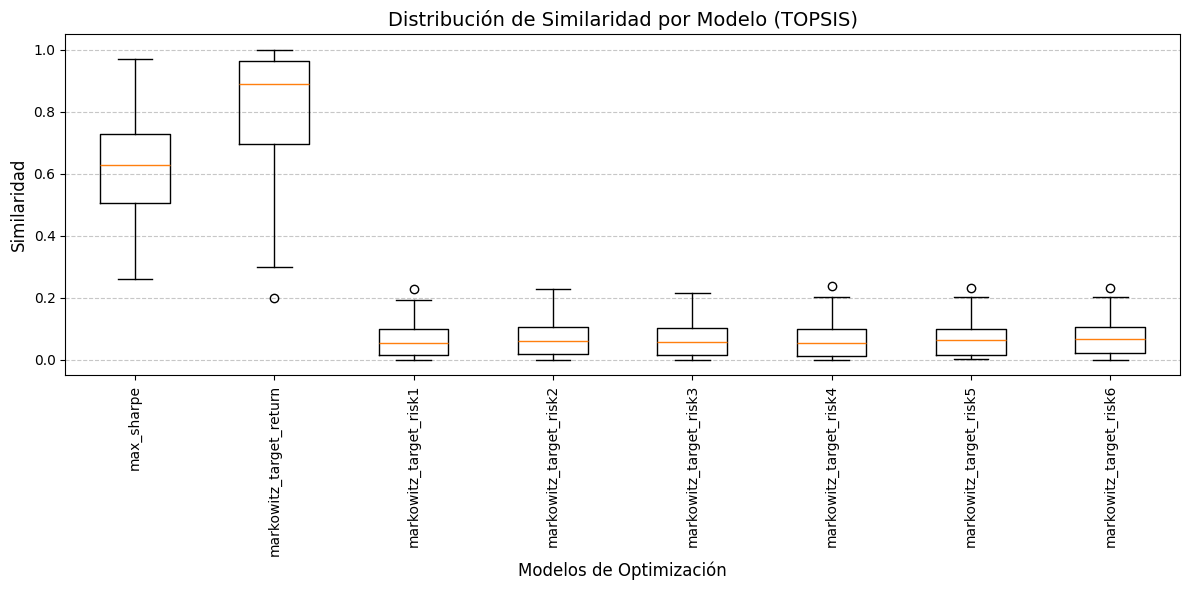

In [33]:
# Crear la figura y los ejes
plt.figure(figsize=(12, 6))

# Generar el boxplot
# labels=df_similaridad_total.columns asigna el nombre de los modelos al eje X
plt.boxplot(df_similaridad_total.values, labels=df_similaridad_total.columns)

# === Configuración de etiquetas ===
# rotation=90 para que queden verticales (como pediste en el rot=90 de pandas)
# ha='center' para que el texto esté centrado bajo la marca
plt.xticks(rotation=90, ha='center', fontsize=10)

# Añadir títulos y etiquetas para claridad profesional
plt.title('Distribución de Similaridad por Modelo (TOPSIS)', fontsize=14)
plt.ylabel('Similaridad', fontsize=12)
plt.xlabel('Modelos de Optimización', fontsize=12)

# Añadir una cuadrícula ligera solo en el eje Y para facilitar la lectura
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar el diseño para que no se corten las etiquetas inferiores
plt.tight_layout()

plt.show()

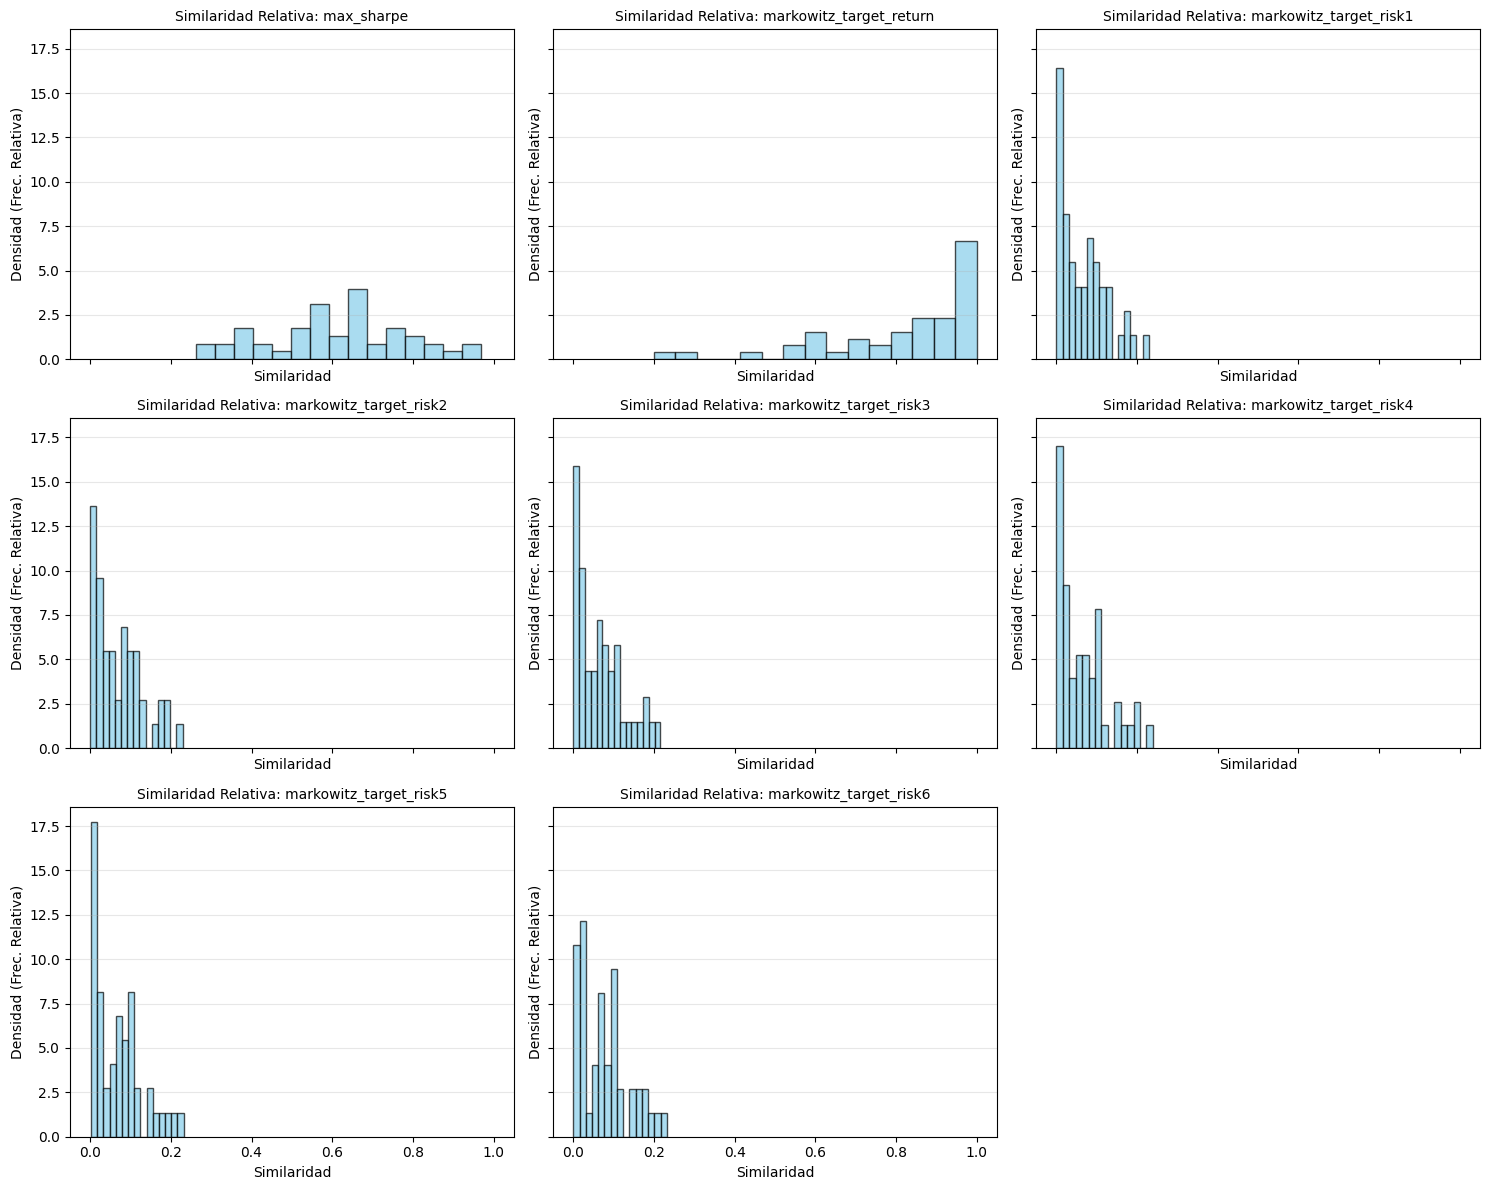

In [41]:
# 1. Configuración de la grilla
modelos = df_similaridad_total.columns
n_modelos = len(modelos)
n_cols = 3  # Puedes ajustar el número de columnas
n_rows = math.ceil(n_modelos / n_cols)

# 2. Crear la figura y los subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), sharey=True, sharex=True)
axes = axes.flatten() # Aplanar para iterar fácilmente

# 3. Bucle para generar cada histograma
for i, modelo in enumerate(modelos):
    ax = axes[i]
    
    # CAMBIO AQUÍ: Agregamos density=True
    ax.hist(df_similaridad_total[modelo], bins=15, color='skyblue', 
            edgecolor='black', alpha=0.7, density=True)
    
    ax.set_title(f'Similaridad Relativa: {modelo}', fontsize=10)
    ax.set_xlabel('Similaridad')
    ax.set_ylabel('Densidad (Frec. Relativa)')
    ax.grid(axis='y', alpha=0.3)

# 4. Limpiar subplots vacíos (si n_modelos no es múltiplo de n_cols)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar espaciado
plt.tight_layout()
plt.show()

In [35]:
objectives = [
    max, #     'stocks_seleccionados', coincide con definición mayor número de stocks
    min, #     'Entropia_cruzada', mide el desorden al compararlo con una estrategia teórica de risk part equally
    max, #     'Entropia_Zheng', 
    max, #     'Ratio_diversific', mide la diversificación ganada por  mantener activos no correlacionados
    min, #     'CV_Contribuciones_marginales', si todos los activos tienen igual contribución marginal es un portfolio diversificado
    max, #     'Indice_diversific_port, si hay correlacióan alta el índice dará un valor bajo mientras que si no hay correlación el índice tenderá al valor N
]
dm = skc.mkdm(df_metricas_limpio[df_metricas_limpio.index.get_level_values('Ventana') == 3].to_numpy(), 
              objectives, alternatives=df_metricas_limpio[df_metricas_limpio.index.get_level_values('Ventana') == 3].index, 
              criteria=df_metricas_limpio[df_metricas_limpio.index.get_level_values('Ventana') == 3].columns)

In [36]:
pipe_igual_vector = pipeline.mkpipe(
    invert_objectives.NegateMinimize(),
    scalers.VectorScaler(target="matrix"),
    weighters.EqualWeighter(),
    similarity.TOPSIS(),
)
pipe_igual_vector
result_igual_vector = pipe_igual_vector.evaluate(dm)
result_igual_vector

Alternatives,"(3, 1, 'max_sharpe')","(3, 1, 'markowitz_target_return')","(3, 1, 'markowitz_target_risk1')","(3, 1, 'markowitz_target_risk2')","(3, 1, 'markowitz_target_risk3')","(3, 1, 'markowitz_target_risk4')","(3, 1, 'markowitz_target_risk5')","(3, 1, 'markowitz_target_risk6')","(3, 2, 'max_sharpe')","(3, 2, 'markowitz_target_return')","(3, 2, 'markowitz_target_risk1')","(3, 2, 'markowitz_target_risk2')","(3, 2, 'markowitz_target_risk3')","(3, 2, 'markowitz_target_risk4')","(3, 2, 'markowitz_target_risk5')","(3, 2, 'markowitz_target_risk6')","(3, 3, 'max_sharpe')","(3, 3, 'markowitz_target_return')","(3, 3, 'markowitz_target_risk1')","(3, 3, 'markowitz_target_risk2')","(3, 3, 'markowitz_target_risk3')","(3, 3, 'markowitz_target_risk4')","(3, 3, 'markowitz_target_risk5')","(3, 3, 'markowitz_target_risk6')","(3, 4, 'max_sharpe')","(3, 4, 'markowitz_target_return')","(3, 4, 'markowitz_target_risk1')","(3, 4, 'markowitz_target_risk2')","(3, 4, 'markowitz_target_risk3')","(3, 4, 'markowitz_target_risk4')","(3, 4, 'markowitz_target_risk5')","(3, 4, 'markowitz_target_risk6')","(3, 5, 'max_sharpe')","(3, 5, 'markowitz_target_return')","(3, 5, 'markowitz_target_risk1')","(3, 5, 'markowitz_target_risk2')","(3, 5, 'markowitz_target_risk3')","(3, 5, 'markowitz_target_risk4')","(3, 5, 'markowitz_target_risk5')","(3, 5, 'markowitz_target_risk6')","(3, 7, 'max_sharpe')","(3, 7, 'markowitz_target_return')","(3, 7, 'markowitz_target_risk1')","(3, 7, 'markowitz_target_risk2')","(3, 7, 'markowitz_target_risk3')","(3, 7, 'markowitz_target_risk4')","(3, 7, 'markowitz_target_risk5')","(3, 7, 'markowitz_target_risk6')","(3, 9, 'max_sharpe')","(3, 9, 'markowitz_target_return')","(3, 9, 'markowitz_target_risk1')","(3, 9, 'markowitz_target_risk2')","(3, 9, 'markowitz_target_risk3')","(3, 9, 'markowitz_target_risk4')","(3, 9, 'markowitz_target_risk5')","(3, 9, 'markowitz_target_risk6')","(3, 11, 'max_sharpe')","(3, 11, 'markowitz_target_return')","(3, 11, 'markowitz_target_risk1')","(3, 11, 'markowitz_target_risk2')","(3, 11, 'markowitz_target_risk3')","(3, 11, 'markowitz_target_risk4')","(3, 11, 'markowitz_target_risk5')","(3, 11, 'markowitz_target_risk6')","(3, 13, 'max_sharpe')","(3, 13, 'markowitz_target_return')","(3, 13, 'markowitz_target_risk1')","(3, 13, 'markowitz_target_risk2')","(3, 13, 'markowitz_target_risk3')","(3, 13, 'markowitz_target_risk4')","(3, 13, 'markowitz_target_risk5')","(3, 13, 'markowitz_target_risk6')","(3, 14, 'max_sharpe')","(3, 14, 'markowitz_target_return')","(3, 14, 'markowitz_target_risk1')","(3, 14, 'markowitz_target_risk2')","(3, 14, 'markowitz_target_risk3')","(3, 14, 'markowitz_target_risk4')","(3, 14, 'markowitz_target_risk5')","(3, 14, 'markowitz_target_risk6')","(3, 17, 'max_sharpe')","(3, 17, 'markowitz_target_return')","(3, 17, 'markowitz_target_risk1')","(3, 17, 'markowitz_target_risk2')","(3, 17, 'markowitz_target_risk3')","(3, 17, 'markowitz_target_risk4')","(3, 17, 'markowitz_target_risk5')","(3, 17, 'markowitz_target_risk6')","(3, 21, 'max_sharpe')","(3, 21, 'markowitz_target_return')","(3, 21, 'markowitz_target_risk1')","(3, 21, 'markowitz_target_risk2')","(3, 21, 'markowitz_target_risk3')","(3, 21, 'markowitz_target_risk4')","(3, 21, 'markowitz_target_risk5')","(3, 21, 'markowitz_target_risk6')","(3, 25, 'max_sharpe')","(3, 25, 'markowitz_target_return')","(3, 25, 'markowitz_target_risk1')","(3, 25, 'markowitz_target_risk2')","(3, 25, 'markowitz_target_risk3')","(3, 25, 'markowitz_target_risk4')","(3, 25, 'markowitz_target_risk5')","(3, 25, 'markowitz_target_risk6')","(3, 27, 'max_sharpe')","(3, 27, 'markowitz_target_return')","(3, 27, 'markowitz_target_risk1')","(3, 27, 'markowitz_target_risk2')","(3, 27, 'markowitz_target_risk3')","(3, 27, 'markowitz_target_risk4')","(3, 27, 'markowitz_target_risk5')","(3, 27, 'markowitz_target_risk6')","(3, 28, 'max_sharpe')","(3, 28, 'markowitz_target_return')","(3, 28, 'markowitz_target_risk1')","(3, 28, 'markowitz_target_risk2')","(3, 28, 'markowitz_target_risk3